# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


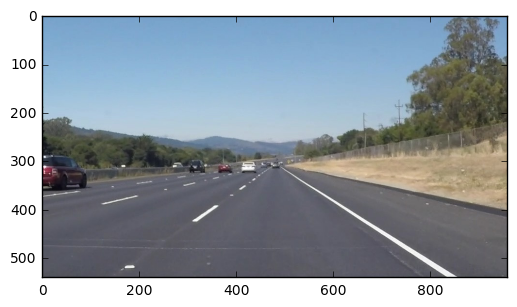

In [49]:
#reading in an image
#generify image reading.  
def read_image(image_path):
    print('This image is:', type(image), 'with dimesions:', image.shape)
    plt.imshow(image) 
    return mpimg.imread(image_path)

image = read_image('test_images/solidWhiteRight.jpg'); 


In [ ]:
#the above output is the image from solidWhiteRight.jpg...doesn't actually do anything yet. 

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [211]:
import math

#i think this is a typo? should be greyscale ? 
#...on second review, turns out you can spell it either or... T.I.L. 
def greyscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #my hypothetical vertices. start bottom left at 100, 540, starting bottom right at 900,540)
    vertices = np.array(
    [[(100, 540),#bot left 
    (400, 340),#top left
    (600, 340),#top right
    (900, 540)]] #bottom right
    )
    #we always want x value when y = 540 (bottom of image as a point.)
    #take the "upper"point and connect. //because i make the gap super big, we should only end up with limited lines. 
    leftLinePointsX = []  #grab max x
    leftLinePointsY = []  #grab max x
    rightLinePointsX= []  #grab min x
    rightLinePointsY = []
    leftLineIntersects= [] #average all x value at 540. 
    rightLineIntersects = [] #average all x value at 540. 
    
    for line in lines:
        for x1,y1,x2,y2 in line:           
            slope = ((y2-y1)/(x2-x1))
            length = math.sqrt((y2-y1)**2 + (x2-x1)**2)
            if length > 50:  #we onl really care about long lines. i make gap super high.  
                #print('x1:', x1,'y1:', y1, 'x2:', x2,'y2:',y2,'slope',slope, 'length', length)
                if slope < 0:
                    #this means it's part of left line.  
                    #y=mx+b.  b = y-mx  y = 540. m=slope. we can find the intersection b 
                    #taking the equation, we want the value of x when it cross y = 540.  
                    b = y1-slope*x1
                    x= (540-b)/slope
                    if x1>x2:
                        leftLinePointsX.append(x1)
                        leftLinePointsY.append(y1)
                    else:
                        leftLinePointsX.append(x2)
                        leftLinePointsY.append(y2)
                    leftLineIntersects.append(x)
                else:
                    #this mean it's part of right
                    b = y2-slope*x2 
                    x= (540-b)/slope 
                    if (x1>x2):
                        rightLinePointsX.append(x2)
                        rightLinePointsY.append(y2)
                    else: 
                        rightLinePointsX.append(x1)
                        rightLinePointsY.append(y1)
                    rightLineIntersects.append(x)
    topLeftX=np.amax(leftLinePointsX)
    topLeftY=np.amin(leftLinePointsY)
    topRightX=np.amin(rightLinePointsX)
    topRightY=np.amin(rightLinePointsY)
    botLeftX=np.mean(leftLineIntersects) #bottom
    botRightX=np.mean(rightLineIntersects) #bottom rigth is (mean, 540) 
    #print(leftLinePointsX)
    #print(leftLinePointsY)
    #print(rightLinePointsX)
    #print(rightLinePointsY)
    #print(leftLineIntersects)
    #print(rightLineIntersects)
    #print(botLeftX)
    #print(botRightX)
    
    ##left line
    cv2.line(img,(int(min(botLeftX,200)),540),(topLeftX, topLeftY),color,3)
    print(botLeftX)
    ##right line
    print(botRightX)
    cv2.line(img,(topRightX,topRightY) ,(int(min(botRightX, 900)),540),color,3)
      
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
194.211457689
881.015909746


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

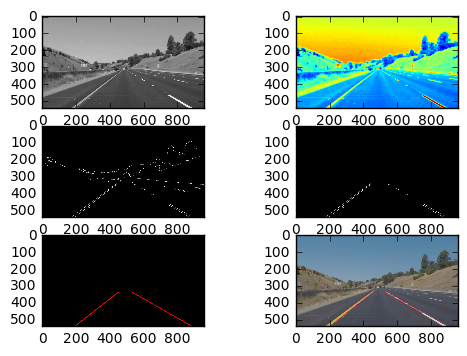

In [212]:
#we want to run the "pipeline solution" on every image. 
#basic pipeline: 
#1) read an image
#2) call greyscale an image. 
#3) see the greyscale image.  --> some what the same as color selection
#4) apply gaussian smoothing to lose details
#5) apply canny edge detection 
#6) restrict the "vision" to only part of the image. Defined by vertices on the image. 
#7) apply h-transform. 
#8) draw the lines. 

import os
samples = list()  #this stores the images after reading them. 
for i in os.listdir('test_images/'):
    samples.append(read_image("test_images/"+i))

def pipelineProcess(image):
    
    greyImage = greyscale(image)
    plt.subplot(3,2,1)
    plt.imshow(greyImage, cmap="gray")
    
    lessNoiseImage = gaussian_blur(greyImage,9) #picked 9 to be smooth..this is trial & error.  
    plt.subplot(3,2,2)
    plt.imshow(lessNoiseImage)
    
    #we now need to roughly define the area where we want to look fo rlines. 
    
    cannyEdgedImage = canny(lessNoiseImage, 75, 150) #detectEdges
    plt.subplot(3,2,3)
    plt.imshow(cannyEdgedImage, cmap="gray")
    
    #define my vertices for ROI. 
    #this is somewhat tricky. 
    #I expect ROI to move as we drive...but it's rouglhly bottom left, to center, bottom righ tot center
    #I am going to hard code define a trapezoid for this project, but ideally we should find linear fit models 
    vertices = np.array(
    [[(100, 540),#bot left 
    (400, 340),#top left
    (600, 340),#top right
    (900, 540)]] #bottom right
    )
    
    maskedCannyImage = region_of_interest(cannyEdgedImage, vertices)
    plt.subplot(3,2,4)
    plt.imshow(maskedCannyImage, cmap="gray")
    
    #now the harder part...defining Hough Transform parameters. 
    #the previous edges looks okay to me based on region defined.
    #lowering the gaussian blur may make lines more pronounced onger on image 1,2. 
    #but most of the "none-relevant" points has been cleaned after the mask.
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 150 
    linesImage = hough_lines(maskedCannyImage, rho, theta, threshold,
                            min_line_length, max_line_gap)
    plt.subplot(3,2,5)
    plt.imshow(linesImage, cmap="gray")
    
    finished = weighted_img(linesImage, image)
    ## Plot final image
    plt.subplot(3,2,6)
    plt.imshow(finished)
    
    return finished
    
#for sample in samples: 
#    pipelineProcess(sample)
#pipelineProcess(samples[0]) #...crap...what about the area w/out lines...on bottom left
#pipelineProcess(samples[1]) #looks good
#pipelineProcess(samples[2]) #looks good too..but bottom right. 
#pipelineProcess(samples[3]) #looks awesome
#pipelineProcess(samples[4])  #bottom right..
pipelineProcess(samples[5])  #this was what i used to developed the pipeline..this looks best. 

#not quite sure how to handle the lacking "line" areas in image 1 on bottom left. 
    
    

147.774519268
855.58623035


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

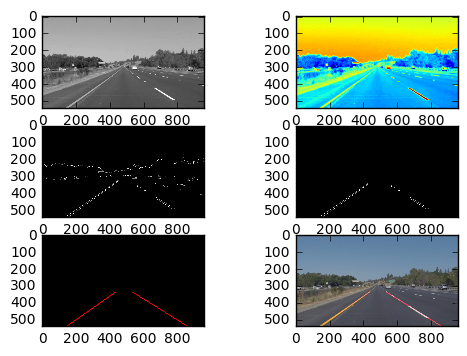

In [213]:
pipelineProcess(samples[4])

174.308270213
865.888839085


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

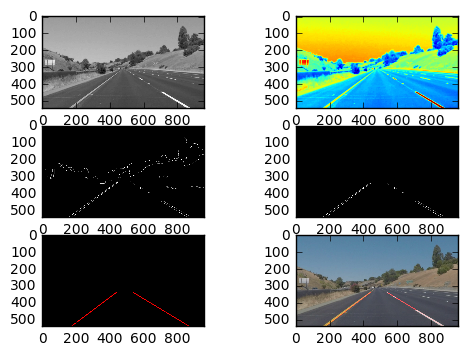

In [214]:
pipelineProcess(samples[3])

run your solution on all test_images and make copies into the test_images directory).

170.424991623
850.289344898


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ..., 
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ..., 
       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,

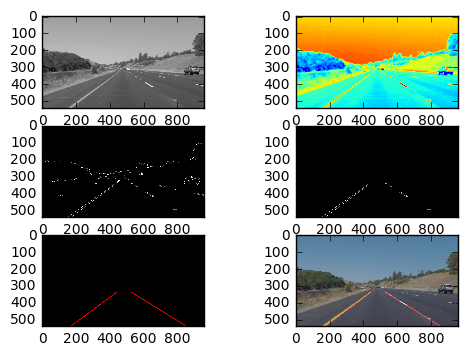

In [215]:
pipelineProcess(samples[2])

154.953537854
847.061482495


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

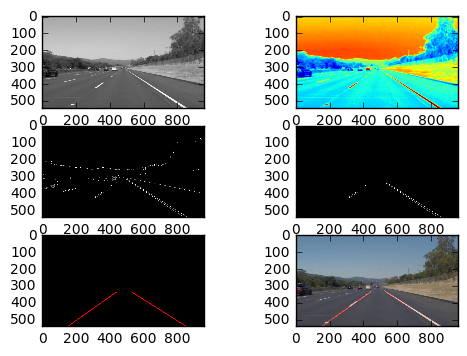

In [216]:
pipelineProcess(samples[1])

186.835273662
891.40641445


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

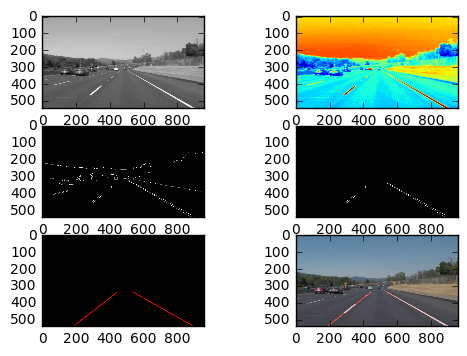

In [217]:
pipelineProcess(samples[0])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [186]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [187]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipelineProcess(image)
    return result

Let's try the one with the solid white lane on the right first ...

147.455341009
865.665962794
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4







  0%|          | 0/222 [00:00<?, ?it/s]

147.455341009
865.665962794







  1%|          | 2/222 [00:00<00:16, 13.70it/s]

156.095063364
864.529697473
157.159670959
871.25069519







  2%|▏         | 4/222 [00:00<00:15, 13.96it/s]

152.397104782
862.3751227







  3%|▎         | 6/222 [00:00<00:15, 14.08it/s]

158.063407897
862.598934427
155.258500198
861.037406658


145.200115643
872.130899641







  4%|▎         | 8/222 [00:00<00:15, 14.00it/s]

163.210437454
870.095838582
148.686219586
863.868087774







  5%|▍         | 10/222 [00:00<00:14, 14.37it/s]

152.746448273
864.088749938







  5%|▌         | 12/222 [00:00<00:14, 14.39it/s]

163.038673853
844.250523913
156.945481179
846.050143433


152.840173599
847.068797833







  6%|▋         | 14/222 [00:00<00:14, 14.02it/s]

149.493929554
845.209131107
147.956805067
847.115515735







  7%|▋         | 16/222 [00:01<00:14, 13.76it/s]

144.764832049
860.662169517







  8%|▊         | 18/222 [00:01<00:14, 13.97it/s]

139.937888357
841.47996782
142.969735449
854.78599348


137.474163172
843.558394412







  9%|▉         | 20/222 [00:01<00:14, 13.96it/s]

146.641639543
845.828265668
149.697273943
844.13972722







 10%|▉         | 22/222 [00:01<00:14, 14.07it/s]

146.417112887
844.272924829







 11%|█         | 24/222 [00:01<00:14, 13.94it/s]

147.42576482
846.190024269
150.341696424
848.834162329


139.212932518
848.745753013







 12%|█▏        | 26/222 [00:01<00:14, 13.88it/s]

153.509812866
845.959038652
139.963095154
847.48216654







 13%|█▎        | 28/222 [00:02<00:14, 13.75it/s]

152.620012714
841.629369676







 14%|█▎        | 30/222 [00:02<00:14, 13.43it/s]

151.125110754
847.135053883
143.034851552
845.503620657


144.500411562
848.270905632







 14%|█▍        | 32/222 [00:02<00:14, 13.15it/s]

154.708724131
837.394369807
152.683224521
851.659446056







 15%|█▌        | 34/222 [00:02<00:13, 13.72it/s]

147.573392575
849.999189797
153.579723055
856.090587398







 16%|█▌        | 36/222 [00:02<00:13, 14.12it/s]

152.235888936
849.043501265
155.961593285
844.048241005







 17%|█▋        | 38/222 [00:02<00:12, 14.20it/s]

157.495066765
839.351295936







 18%|█▊        | 40/222 [00:02<00:12, 14.28it/s]

162.799860649
832.212116504
161.059558113
836.550116418


151.285118056
843.313554578







 19%|█▉        | 42/222 [00:02<00:12, 14.24it/s]

153.417997403
860.442219708
155.673733607
841.437429405







 20%|█▉        | 44/222 [00:03<00:12, 13.74it/s]

149.606638332
835.405368653







 21%|██        | 46/222 [00:03<00:13, 13.44it/s]

150.77014735
837.892175535
155.553760351
841.709957337


163.540724821
847.406753657







 22%|██▏       | 48/222 [00:03<00:13, 13.12it/s]

151.119356064
848.222913923
147.066633162
850.984232267







 23%|██▎       | 50/222 [00:03<00:13, 13.02it/s]

155.817643941
826.161658825







 23%|██▎       | 52/222 [00:03<00:12, 13.14it/s]

145.706117383
841.670388849
147.135674493
838.731508363


141.027500675
846.184353147







 24%|██▍       | 54/222 [00:03<00:12, 13.10it/s]

124.538375312
843.448027245
135.284106072
843.412092226







 25%|██▌       | 56/222 [00:04<00:12, 13.32it/s]

143.083157153
858.976212589







 26%|██▌       | 58/222 [00:04<00:12, 13.42it/s]

139.933906062
839.181255048
135.502090734
825.561672069


138.923427848
841.35991169







 27%|██▋       | 60/222 [00:04<00:12, 13.37it/s]

140.401368599
840.818289507
141.680693625
834.439363265







 28%|██▊       | 62/222 [00:04<00:12, 13.09it/s]

137.761026789
848.393419015


136.077726963
849.626789336
124.846751539
841.213069625







 29%|██▉       | 64/222 [00:04<00:12, 12.66it/s]

135.541514279
836.866055823







 30%|██▉       | 66/222 [00:04<00:12, 12.57it/s]

129.29064553
837.113700853
133.34025599
850.316556418







 31%|███       | 68/222 [00:05<00:12, 12.59it/s]

123.478141217
843.804788269







 32%|███▏      | 70/222 [00:05<00:12, 12.52it/s]

134.804163033
845.267437923
127.728549957
833.965068626


125.505365734
841.28214479







 32%|███▏      | 72/222 [00:05<00:11, 12.71it/s]

117.217641509
829.219730051
131.062960157
832.154866453







 33%|███▎      | 74/222 [00:05<00:11, 12.96it/s]

133.674235506
834.756972374







 34%|███▍      | 76/222 [00:05<00:10, 13.40it/s]

118.288850068
833.931641126
118.485348766
830.446241227


121.831177928
829.738288252
127.288544955
829.799348671







 35%|███▌      | 78/222 [00:05<00:10, 13.89it/s]

130.271162747
843.587480241
129.004896539
827.866230861







 36%|███▌      | 80/222 [00:05<00:09, 14.25it/s]

127.53811646
832.16516053
126.347468987
823.655054778







 37%|███▋      | 82/222 [00:06<00:09, 14.47it/s]

122.564766082
841.148896728







 38%|███▊      | 84/222 [00:06<00:09, 14.28it/s]

117.478161461
833.852222597
123.439845901
827.063813491







 39%|███▊      | 86/222 [00:06<00:09, 14.04it/s]

122.419698202
819.149467141







 40%|███▉      | 88/222 [00:06<00:09, 13.66it/s]

122.994773492
819.948186685
124.138346951
836.787123193


135.653090797
826.69650037







 41%|████      | 90/222 [00:06<00:10, 13.20it/s]

126.153297032
823.619121705
122.88916545
811.699118715







 41%|████▏     | 92/222 [00:06<00:09, 13.33it/s]

122.691286259
821.829981969







 42%|████▏     | 94/222 [00:06<00:09, 13.16it/s]

124.550644176
824.177948848
123.793469101
820.160263167


123.822714917
827.063452327







 43%|████▎     | 96/222 [00:07<00:09, 12.99it/s]

116.220700347
816.492037558
126.562389175
819.721699453







 44%|████▍     | 98/222 [00:07<00:09, 13.03it/s]

126.809818378
816.471722105







 45%|████▌     | 100/222 [00:07<00:09, 13.24it/s]

123.488108355
821.15672717
119.325450524
824.425601822


126.622571406
824.529699308







 46%|████▌     | 102/222 [00:07<00:09, 13.19it/s]

132.35302841
814.539964006
132.957809051
823.405520684







 47%|████▋     | 104/222 [00:07<00:08, 13.49it/s]

141.433696251
821.216625236







 48%|████▊     | 106/222 [00:07<00:08, 13.80it/s]

143.232122339
827.75655298
133.687373014
823.470517677


139.943749691
829.070172244







 49%|████▊     | 108/222 [00:07<00:08, 13.46it/s]

142.101193728
831.529402211
146.505167386
832.125342963







 50%|████▉     | 110/222 [00:08<00:08, 13.60it/s]

125.481467174
826.858093859







 50%|█████     | 112/222 [00:08<00:07, 13.76it/s]

139.243113157
834.283955821
133.277908007
828.245304081


135.763613263
835.349755721







 51%|█████▏    | 114/222 [00:08<00:08, 13.38it/s]

146.506825651
inf
138.679001173
834.86374994







 52%|█████▏    | 116/222 [00:08<00:07, 13.79it/s]

128.501516135
836.496234822







 53%|█████▎    | 118/222 [00:08<00:07, 13.81it/s]

123.00372845
841.821067799
128.682617767
836.801969131


122.791683021
846.068671013







 54%|█████▍    | 120/222 [00:08<00:07, 13.79it/s]

128.808508875
840.764686284
139.788418375
854.129122406







 55%|█████▍    | 122/222 [00:08<00:07, 14.03it/s]

150.872180203
849.619140047







 56%|█████▌    | 124/222 [00:09<00:07, 13.70it/s]

145.812928709
857.114797843
144.827816736
854.476325361


138.380944348
845.699573211







 57%|█████▋    | 126/222 [00:09<00:08, 11.59it/s]

136.495573715
848.796935795







 58%|█████▊    | 128/222 [00:09<00:07, 11.86it/s]

146.502624618
843.759449462
144.675822565
854.622394766


152.056499121
854.933134829







 59%|█████▊    | 130/222 [00:09<00:07, 11.78it/s]

161.696661345
855.889879594
153.258550262
857.022065589







 59%|█████▉    | 132/222 [00:09<00:07, 12.36it/s]

160.789374718
851.21010304







 60%|██████    | 134/222 [00:10<00:07, 12.26it/s]

163.033905746
852.071340865
154.292197827
858.37322924


157.450291538
853.109250081







 61%|██████▏   | 136/222 [00:10<00:06, 12.94it/s]

148.746223275
859.1427608
151.101267534
866.328436157







 62%|██████▏   | 138/222 [00:10<00:06, 12.96it/s]

143.557445912
847.83654238







 63%|██████▎   | 140/222 [00:10<00:06, 13.30it/s]

152.692930544
856.327457456
153.496176629
856.989732029


142.889999144
861.496390267







 64%|██████▍   | 142/222 [00:10<00:06, 13.21it/s]

157.088650481
838.644174185
152.825801458
851.599043482







 65%|██████▍   | 144/222 [00:10<00:05, 13.48it/s]

162.044001503
851.136544012







 66%|██████▌   | 146/222 [00:10<00:05, 13.52it/s]

162.438989263
841.963285553
158.840161543
856.014017094


150.96588869
869.323939314







 67%|██████▋   | 148/222 [00:11<00:05, 13.28it/s]

159.210466015
854.901784518
159.210183799
857.157237734







 68%|██████▊   | 150/222 [00:11<00:05, 13.64it/s]

154.852624534
853.79069615







 68%|██████▊   | 152/222 [00:11<00:05, 13.48it/s]

159.987992651
860.52392689
163.210797767
847.993069183


157.620013483
849.277130737







 69%|██████▉   | 154/222 [00:11<00:05, 13.07it/s]

159.658620116
857.276577818
168.863475079
870.925964034
154.249098698
867.787383512







 70%|███████   | 156/222 [00:11<00:05, 12.42it/s]

163.751586614
886.987879566
163.960439436
881.551730011







 71%|███████   | 158/222 [00:11<00:05, 11.60it/s]




 72%|███████▏  | 160/222 [00:12<00:05, 11.81it/s]

165.574826629
893.376591851
163.858559305
862.517370245
165.060616229
865.93991476







 73%|███████▎  | 162/222 [00:12<00:04, 12.23it/s]




 74%|███████▍  | 164/222 [00:12<00:04, 12.49it/s]

169.893867788
875.079304288
175.511330461
890.966932218
173.241599964
891.152478441







 75%|███████▍  | 166/222 [00:12<00:04, 12.91it/s]

171.696890985
876.942245447
177.592014994
874.393302117
183.28708844
875.666519942







 76%|███████▌  | 168/222 [00:12<00:04, 13.11it/s]




 77%|███████▋  | 170/222 [00:12<00:03, 13.30it/s]

182.13379079
874.306874009
180.536748768
876.962665817
176.510165736
879.800221099







 77%|███████▋  | 172/222 [00:12<00:03, 13.25it/s]

185.342600774
873.37175611
187.555185231
874.325783752
182.955416262
877.286333224







 78%|███████▊  | 174/222 [00:13<00:03, 13.64it/s]




 79%|███████▉  | 176/222 [00:13<00:03, 13.94it/s]

184.469451188
inf
186.078611356
873.718772233
189.518227511
893.044342168







 80%|████████  | 178/222 [00:13<00:03, 14.12it/s]

184.71916745
887.928440941
189.381211799
887.335905175
188.146701885
871.834437768







 81%|████████  | 180/222 [00:13<00:03, 13.87it/s]




 82%|████████▏ | 182/222 [00:13<00:02, 13.70it/s]

194.133591853
880.80208943
190.396875634
890.239961324
195.475852327
890.969424123







 83%|████████▎ | 184/222 [00:13<00:02, 13.15it/s]

188.811064809
891.066416557
190.871468658
880.935352235
190.871434866
867.359764695







 84%|████████▍ | 186/222 [00:13<00:02, 12.99it/s]




 85%|████████▍ | 188/222 [00:14<00:02, 12.77it/s]

188.701368185
867.001553474
194.399574475
882.58407555
183.985109202
883.891896207







 86%|████████▌ | 190/222 [00:14<00:02, 12.61it/s]

175.263727627
896.209168984
179.233932273
892.292101412
181.193981361
904.220191953







 86%|████████▋ | 192/222 [00:14<00:02, 12.83it/s]




 87%|████████▋ | 194/222 [00:14<00:02, 12.69it/s]

181.311466105
895.500753242
185.220631294
885.308654865
193.560053712
875.518773767







 88%|████████▊ | 196/222 [00:14<00:02, 12.65it/s]

183.226375912
881.044168017
192.293096756
895.952692517
185.061414343
879.227939186







 89%|████████▉ | 198/222 [00:14<00:01, 13.16it/s]




 90%|█████████ | 200/222 [00:15<00:01, 13.33it/s]

196.045559843
902.436071035
192.137357927
920.136377862
182.124883406
886.593450088







 91%|█████████ | 202/222 [00:15<00:01, 13.20it/s]

190.164199276
887.132029298
187.705991443
891.042385259
194.244360069
920.335045681







 92%|█████████▏| 204/222 [00:15<00:01, 13.22it/s]




 93%|█████████▎| 206/222 [00:15<00:01, 13.32it/s]

190.641599955
885.815385206
187.253488811
893.655166804
177.177302006
900.026499323







 94%|█████████▎| 208/222 [00:15<00:01, 13.15it/s]

191.855012884
900.885754853
176.268631914
898.630521159
176.731477849
897.751890172







 95%|█████████▍| 210/222 [00:15<00:00, 13.13it/s]




 95%|█████████▌| 212/222 [00:15<00:00, 13.25it/s]

175.049808528
897.716104792
187.755744326
891.815424779
178.149249137
899.672265937







 96%|█████████▋| 214/222 [00:16<00:00, 13.52it/s]

188.561441689
893.441427054
177.109531832
892.807828283
190.215107035
894.156552773







 97%|█████████▋| 216/222 [00:16<00:00, 13.51it/s]




 98%|█████████▊| 218/222 [00:16<00:00, 13.54it/s]

188.413737472
889.272936913
186.250644129
890.920677668
188.006214593
888.525477639







 99%|█████████▉| 220/222 [00:16<00:00, 13.35it/s]




100%|█████████▉| 221/222 [00:16<00:00, 13.30it/s]

182.852761035
891.988824348
187.783972238
889.172147312
179.580910624
900.013223752


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 15.1 s, sys: 1.62 s, total: 16.7 s
Wall time: 17.1 s


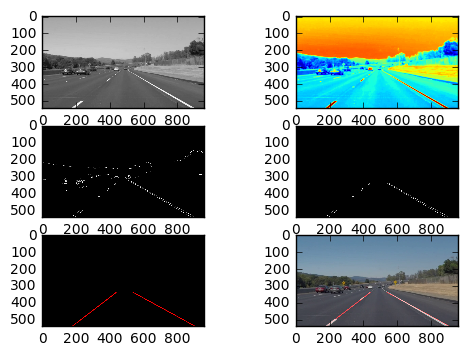

In [218]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [219]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

105.423586163
838.742458847
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4







  0%|          | 0/682 [00:00<?, ?it/s]

105.423586163
838.742458847







  0%|          | 2/682 [00:00<00:52, 13.00it/s]

114.44031888
830.804453355


110.09195892
834.226262247
115.235768592
827.97685846







  1%|          | 4/682 [00:00<00:52, 12.82it/s]

123.597307838
846.008805233







  1%|          | 6/682 [00:00<00:51, 13.21it/s]

55.466225719
846.593565193


130.940388213
851.688021053







  1%|          | 8/682 [00:00<00:50, 13.45it/s]

128.100812333
839.882149726


119.559279563
846.76701858







  1%|▏         | 10/682 [00:00<00:50, 13.21it/s]

130.777782709
842.81863262


138.638496592
843.249972888







  2%|▏         | 12/682 [00:00<00:49, 13.65it/s]

135.633960252
858.860941383


133.243601683
846.93013738







  2%|▏         | 14/682 [00:01<00:49, 13.53it/s]

153.272509958
842.446276607


133.953561031
848.241100918







  2%|▏         | 16/682 [00:01<00:48, 13.85it/s]

145.371354132
850.779869559


142.924157352
855.284849562







  3%|▎         | 18/682 [00:01<00:47, 13.87it/s]

142.657199352
866.096966804


140.563405256
861.858348773







  3%|▎         | 20/682 [00:01<00:48, 13.64it/s]

142.765007373
861.121981457


141.108381379
859.376313396







  3%|▎         | 22/682 [00:01<00:49, 13.42it/s]

140.895659544
857.070337913


141.907660534
854.606687797
139.964761589
854.640243384







  4%|▎         | 24/682 [00:01<00:50, 12.93it/s]

149.278958777
857.948402416







  4%|▍         | 26/682 [00:01<00:50, 12.89it/s]

143.365935262
859.704573082


148.877937115
857.112859313







  4%|▍         | 28/682 [00:02<00:50, 12.93it/s]

161.445891897
872.35603679


157.983280859
873.365318392







  4%|▍         | 30/682 [00:02<00:48, 13.45it/s]

166.371833167
874.736623717


147.250847775
867.215898761







  5%|▍         | 32/682 [00:02<00:48, 13.43it/s]

151.987365724
865.963389874


155.729110534
868.891507945







  5%|▍         | 34/682 [00:02<00:46, 13.92it/s]

155.432009258
864.950375446
151.565925029
860.345512048







  5%|▌         | 36/682 [00:02<00:45, 14.05it/s]

153.486482969
872.378252522
161.078571219
878.499244487







  6%|▌         | 38/682 [00:02<00:44, 14.42it/s]

161.318012295
887.282934229
147.853461485
875.645651257







  6%|▌         | 40/682 [00:02<00:43, 14.74it/s]

155.251256712
870.737433471
144.501126815
886.739243016







  6%|▌         | 42/682 [00:03<00:43, 14.74it/s]

159.649342615
875.086528448
79.3756971124
872.50161846







  6%|▋         | 44/682 [00:03<00:44, 14.43it/s]

153.449728277
878.75643807







  7%|▋         | 46/682 [00:03<00:42, 14.83it/s]

158.083417983
855.668815845
147.471313123
870.20123366
154.657234881
872.926936253







  7%|▋         | 48/682 [00:03<00:44, 14.31it/s]




  7%|▋         | 50/682 [00:03<00:45, 13.81it/s]

145.086811773
862.08163134
156.712910774
867.16287555
152.467233125
869.24697635







  8%|▊         | 52/682 [00:03<00:44, 14.11it/s]

151.66252265
869.448386642
150.102675909
871.079127158
151.929937288
860.66379356
154.969767192
874.736948454







  8%|▊         | 54/682 [00:03<00:43, 14.41it/s]




  8%|▊         | 56/682 [00:04<00:42, 14.71it/s]

153.306057903
875.188622716
154.47090765
853.464755441
144.969415238
868.418498168
150.952350078
873.141675553







  9%|▊         | 58/682 [00:04<00:41, 14.94it/s]




  9%|▉         | 60/682 [00:04<00:41, 14.92it/s]

150.409591995
862.54119272
148.198841971
860.897673996
146.980194894
847.407290482
143.067984885
860.81961674







  9%|▉         | 62/682 [00:04<00:40, 15.29it/s]




  9%|▉         | 64/682 [00:04<00:40, 15.20it/s]

138.603818107
863.386876002
139.370555232
865.902822972
144.700985572
866.393875841
143.426672809
866.353116331







 10%|▉         | 66/682 [00:04<00:40, 15.15it/s]




 10%|▉         | 68/682 [00:04<00:41, 14.89it/s]

147.182990938
861.335431408
139.025151271
857.133506884
148.24795701
868.065311949
144.524122117
860.136031216







 10%|█         | 70/682 [00:04<00:40, 15.15it/s]




 11%|█         | 72/682 [00:05<00:41, 14.79it/s]

146.360373762
867.085236553
144.75842412
851.133102311
136.598517635
855.666986163







 11%|█         | 74/682 [00:05<00:42, 14.43it/s]




 11%|█         | 76/682 [00:05<00:41, 14.43it/s]

150.784758501
848.915305505
147.665818245
853.931407104
151.203156434
845.854608549







 11%|█▏        | 78/682 [00:05<00:42, 14.21it/s]

148.842762589
847.310765487
142.953989998
848.875102013
148.436421093
840.816067402







 12%|█▏        | 80/682 [00:05<00:42, 14.13it/s]




 12%|█▏        | 82/682 [00:05<00:42, 14.15it/s]

159.320129363
845.59760695
139.11103033
846.327707267
143.742460322
857.625785908







 12%|█▏        | 84/682 [00:05<00:44, 13.55it/s]

143.981146401
845.349892873
143.479212804
844.584032633
142.15232672
846.227579367







 13%|█▎        | 86/682 [00:06<00:43, 13.70it/s]




 13%|█▎        | 88/682 [00:06<00:42, 14.07it/s]

149.862867993
838.533332839
144.823369116
868.731158292
137.925730354
853.130053009
139.519960432
846.900796265







 13%|█▎        | 90/682 [00:06<00:42, 13.84it/s]




 13%|█▎        | 92/682 [00:06<00:41, 14.17it/s]

125.02449995
860.613337937
138.71689669
847.99928161
140.374862066
846.295920753







 14%|█▍        | 94/682 [00:06<00:42, 13.82it/s]

141.103189744
846.16056396
145.160882424
854.129704785
139.452281925
840.630420532







 14%|█▍        | 96/682 [00:06<00:41, 14.09it/s]




 14%|█▍        | 98/682 [00:06<00:40, 14.44it/s]

140.569810679
852.9951375
145.37816146
846.750313258
141.067599254
845.60536625







 15%|█▍        | 100/682 [00:07<00:41, 14.18it/s]

153.720163443
843.373402227
147.439135199
837.855220351
143.493192309
839.130732682
143.116989362
854.589985786







 15%|█▍        | 102/682 [00:07<00:40, 14.31it/s]




 15%|█▌        | 104/682 [00:07<00:40, 14.24it/s]

136.09449706
859.036082531
138.957828467
837.413619488
139.221490474
842.893822645







 16%|█▌        | 106/682 [00:07<00:40, 14.31it/s]




 16%|█▌        | 108/682 [00:07<00:40, 14.22it/s]

131.540978966
inf
137.296656945
871.834392652
139.498139346
851.513476296







 16%|█▌        | 110/682 [00:07<00:41, 13.89it/s]

141.913921143
852.563793525
149.477293813
849.705390646
141.796653189
848.872901694







 16%|█▋        | 112/682 [00:07<00:39, 14.26it/s]




 17%|█▋        | 114/682 [00:08<00:39, 14.32it/s]

139.689540624
856.716691132
141.299242094
840.644311018
144.894296553
841.696826814







 17%|█▋        | 116/682 [00:08<00:39, 14.19it/s]

140.331873504
847.809348382
139.049934894
849.790213449
142.693671419
840.426166989







 17%|█▋        | 118/682 [00:08<00:39, 14.12it/s]




 18%|█▊        | 120/682 [00:08<00:40, 13.91it/s]

146.385119152
847.330861895
106.995356911
853.657096455
142.840144368
843.844721986







 18%|█▊        | 122/682 [00:08<00:41, 13.39it/s]

151.679169987
852.652413532
140.43110806
849.902352291
147.242975988
859.182547683







 18%|█▊        | 124/682 [00:08<00:41, 13.54it/s]




 18%|█▊        | 126/682 [00:08<00:40, 13.79it/s]

157.904242402
844.502783869
148.64081509
848.535950657
150.233072283
848.48965902







 19%|█▉        | 128/682 [00:09<00:40, 13.78it/s]

149.191338196
852.24325147
150.621561948
853.261476769
154.18692231
868.943071448







 19%|█▉        | 130/682 [00:09<00:39, 14.01it/s]




 19%|█▉        | 132/682 [00:09<00:38, 14.33it/s]

142.463148971
857.530847655
152.40331922
863.705172821
153.097188357
862.12767183







 20%|█▉        | 134/682 [00:09<00:38, 14.28it/s]

160.505913338
855.465788938
148.552702113
846.957532737
150.951011786
844.091423776







 20%|█▉        | 136/682 [00:09<00:37, 14.39it/s]




 20%|██        | 138/682 [00:09<00:37, 14.41it/s]

156.213857573
847.440366303
150.278318699
849.125860535
148.998804244
840.4891057







 21%|██        | 140/682 [00:09<00:37, 14.59it/s]

154.510417434
854.277080457
148.240835597
845.054961255
141.975450137
848.684747023







 21%|██        | 142/682 [00:10<00:45, 11.74it/s]




 21%|██        | 144/682 [00:10<00:42, 12.54it/s]

152.974069408
844.329737486
150.189485314
844.420799261
153.638941746
844.758188057
150.136155467
858.008037209







 21%|██▏       | 146/682 [00:10<00:40, 13.08it/s]




 22%|██▏       | 148/682 [00:10<00:39, 13.54it/s]

151.662718537
847.598327748
149.574098825
854.068530741
149.178146428
852.956887962
128.567206279
848.892547022







 22%|██▏       | 150/682 [00:10<00:39, 13.54it/s]




 22%|██▏       | 152/682 [00:10<00:38, 13.90it/s]

127.549323753
853.081038157
155.100763092
861.203862247
151.044671731
849.82703492







 23%|██▎       | 154/682 [00:10<00:37, 14.24it/s]

153.143274333
859.274944917
139.934195614
857.937193927
156.710681677
862.894859556
149.731726502
858.582291861







 23%|██▎       | 156/682 [00:11<00:36, 14.42it/s]




 23%|██▎       | 158/682 [00:11<00:35, 14.61it/s]

160.244621034
865.201375139
162.432184801
869.517128519
160.665976136
860.188930863
158.313211464
857.652203804







 23%|██▎       | 160/682 [00:11<00:35, 14.71it/s]




 24%|██▍       | 162/682 [00:11<00:34, 14.89it/s]

164.291961297
859.405597518
164.464314598
856.876980895
164.212051788
878.682249297
166.261508237
861.728086615







 24%|██▍       | 164/682 [00:11<00:35, 14.73it/s]




 24%|██▍       | 166/682 [00:11<00:36, 14.14it/s]

158.746367878
870.77949521
164.372653057
885.149247775
165.731620008
868.081168769







 25%|██▍       | 168/682 [00:11<00:39, 13.13it/s]




 25%|██▍       | 170/682 [00:12<00:38, 13.32it/s]

143.704380484
879.917330177
170.211475222
876.367923772
179.792424869
876.695079186







 25%|██▌       | 172/682 [00:12<00:39, 12.76it/s]

151.613883399
881.534778192
179.798815772
875.721755291
174.394162014
875.47652012







 26%|██▌       | 174/682 [00:12<00:38, 13.21it/s]




 26%|██▌       | 176/682 [00:12<00:38, 13.21it/s]

169.387124491
885.532606841
173.695828249
879.405002206
169.037346346
888.416882284







 26%|██▌       | 178/682 [00:12<00:37, 13.36it/s]

179.583418649
877.181902337
188.122293949
890.643136767
182.686552084
893.273910921







 26%|██▋       | 180/682 [00:12<00:37, 13.51it/s]




 27%|██▋       | 182/682 [00:13<00:35, 14.01it/s]

181.579591924
883.495400497
181.464831521
888.140299752
180.826915452
902.076349698







 27%|██▋       | 184/682 [00:13<00:36, 13.74it/s]

177.416678268
892.858472078
171.494660507
894.682267613
178.60427789
893.420102447







 27%|██▋       | 186/682 [00:13<00:35, 14.07it/s]




 28%|██▊       | 188/682 [00:13<00:36, 13.62it/s]

180.316967927
890.106950144
182.074518003
896.321338186
182.956664724
891.107185653







 28%|██▊       | 190/682 [00:13<00:36, 13.61it/s]

182.248580155
885.271687845
182.422895391
880.124731851
179.772736827
891.818949907







 28%|██▊       | 192/682 [00:13<00:36, 13.54it/s]

174.736085047
886.041871694
181.854273406
896.868985893
181.320102741
899.153614247







 28%|██▊       | 194/682 [00:13<00:37, 13.11it/s]




 29%|██▊       | 196/682 [00:14<00:37, 13.09it/s]

181.691457564
898.712263997
187.637336212
896.006607282
181.526406442
889.696290416







 29%|██▉       | 198/682 [00:14<00:38, 12.62it/s]




 29%|██▉       | 200/682 [00:14<00:37, 12.78it/s]

175.218812315
885.875385391
172.188746977
884.725866866
177.669133486
883.675570127







 30%|██▉       | 202/682 [00:14<00:36, 13.00it/s]

174.532135307
896.56540985
180.802655988
883.028470306
165.74513299
883.446579394







 30%|██▉       | 204/682 [00:14<00:35, 13.30it/s]




 30%|███       | 206/682 [00:14<00:36, 13.18it/s]

173.949734894
876.066174827
178.681947895
878.239135309
156.355638809
887.860778351







 30%|███       | 208/682 [00:14<00:35, 13.38it/s]

174.975551565
880.437656668
174.302160062
866.228465255
174.228098972
876.580718527







 31%|███       | 210/682 [00:15<00:35, 13.41it/s]




 31%|███       | 212/682 [00:15<00:33, 13.83it/s]

167.749674182
868.832984447
165.39590251
870.193969658
167.543534194
881.749295831







 31%|███▏      | 214/682 [00:15<00:34, 13.71it/s]

163.806938413
869.75653026
174.365199498
863.138156771
164.02891869
864.996137565







 32%|███▏      | 216/682 [00:15<00:33, 13.71it/s]

153.696320111
861.183681091
145.371877637
862.751516787
161.792856435
866.054822981







 32%|███▏      | 218/682 [00:15<00:35, 13.01it/s]




 32%|███▏      | 220/682 [00:15<00:36, 12.69it/s]

160.403280358
854.581217047
156.736779645
856.587198511
160.877114145
851.892514297







 33%|███▎      | 222/682 [00:16<00:36, 12.74it/s]




 33%|███▎      | 224/682 [00:16<00:34, 13.10it/s]

157.679419919
860.827334033
152.303029051
860.215481283
163.174436522
864.475391888







 33%|███▎      | 226/682 [00:16<00:34, 13.09it/s]

158.762371817
866.381643674
165.553915191
867.954455542
147.632791971
859.164422594







 33%|███▎      | 228/682 [00:16<00:34, 13.16it/s]




 34%|███▎      | 230/682 [00:16<00:34, 13.14it/s]

163.829489985
859.60270057
158.792403543
868.558585129
156.101041418
852.516855303







 34%|███▍      | 232/682 [00:16<00:33, 13.39it/s]

138.052478414
856.982991377
154.829412584
861.286726964
155.308454538
874.225356869







 34%|███▍      | 234/682 [00:16<00:33, 13.22it/s]




 35%|███▍      | 236/682 [00:17<00:33, 13.30it/s]

156.771407666
863.938461937
152.869195604
858.400054882
148.925808833
869.763222626







 35%|███▍      | 238/682 [00:17<00:33, 13.40it/s]

149.510563379
856.081901311
147.130165099
871.888754626
159.13726543
859.432329727







 35%|███▌      | 240/682 [00:17<00:32, 13.69it/s]




 35%|███▌      | 242/682 [00:17<00:31, 13.78it/s]

150.469132154
868.625582036
153.783542459
880.414122487
149.120358096
868.16724703







 36%|███▌      | 244/682 [00:17<00:32, 13.46it/s]

150.114010727
870.460216529
84.8700720394
885.688406674
142.931598117
855.950297419







 36%|███▌      | 246/682 [00:17<00:32, 13.35it/s]




 36%|███▋      | 248/682 [00:18<00:32, 13.22it/s]

163.768099459
855.833215954
153.202874261
861.0117339
153.623033575
870.846172249







 37%|███▋      | 250/682 [00:18<00:32, 13.12it/s]

148.391460184
867.142449984
157.227044521
863.93181029
152.924778133
855.480820973







 37%|███▋      | 252/682 [00:18<00:32, 13.08it/s]

148.189201229
865.820695668
155.93018139
850.297671881
147.343158568
864.061585871







 37%|███▋      | 254/682 [00:18<00:33, 12.70it/s]




 38%|███▊      | 256/682 [00:18<00:33, 12.56it/s]

166.630821424
855.895418988
163.398433506
858.117934283
165.154329722
853.756894404







 38%|███▊      | 258/682 [00:18<00:33, 12.79it/s]

166.122926305
855.680031471
161.997434001
856.556457888
165.609892836
852.484144494







 38%|███▊      | 260/682 [00:18<00:33, 12.62it/s]




 38%|███▊      | 262/682 [00:19<00:32, 13.07it/s]

165.61446101
858.724669195
159.362704016
852.743948761
164.964281924
858.786629705







 39%|███▊      | 264/682 [00:19<00:31, 13.22it/s]

159.166037863
859.306211037
158.558441558
858.734125512
150.871254868
866.703752863







 39%|███▉      | 266/682 [00:19<00:32, 12.86it/s]




 39%|███▉      | 268/682 [00:19<00:32, 12.68it/s]

158.429162603
872.645146269
158.792441395
858.723211753
149.743555197
856.05670955







 40%|███▉      | 270/682 [00:19<00:31, 12.91it/s]




 40%|███▉      | 272/682 [00:19<00:30, 13.24it/s]

156.872706565
868.514026125
156.026301056
882.504101847
155.353602037
868.940239086







 40%|████      | 274/682 [00:20<00:31, 13.02it/s]

159.427411865
872.257862196
161.208965717
871.240990607
160.69918103
876.543509122







 40%|████      | 276/682 [00:20<00:30, 13.32it/s]




 41%|████      | 278/682 [00:20<00:29, 13.67it/s]

158.574373723
875.648177835
163.473355679
885.450712194
155.23848096
882.268478714







 41%|████      | 280/682 [00:20<00:29, 13.62it/s]

155.241869709
866.50140677
161.249786027
877.56360194
150.506258118
870.44548666







 41%|████▏     | 282/682 [00:20<00:29, 13.79it/s]




 42%|████▏     | 284/682 [00:20<00:28, 13.88it/s]

159.049519326
865.829421336
141.966373939
868.295020019
17.480565661
884.725870935







 42%|████▏     | 286/682 [00:20<00:29, 13.54it/s]

-262.777243825
869.105500999
-599.450431548
877.148895966
121.852871964
981.960575874







 42%|████▏     | 288/682 [00:21<00:29, 13.55it/s]




 43%|████▎     | 290/682 [00:21<00:28, 13.64it/s]

123.895044235
1254.72386611
167.93276854
1591.42994443
107.22396864
1200.82016598







 43%|████▎     | 292/682 [00:21<00:28, 13.55it/s]

142.109441924
882.689817832
113.009568126
inf
155.905885697
853.304436137







 43%|████▎     | 294/682 [00:21<00:28, 13.60it/s]




 43%|████▎     | 296/682 [00:21<00:28, 13.63it/s]

158.710534758
857.549371597
165.483147557
861.73809105
167.551162445
863.232476867







 44%|████▎     | 298/682 [00:21<00:28, 13.41it/s]

160.918958207
862.764700516
159.7191598
853.835203354
172.265125507
855.297225481







 44%|████▍     | 300/682 [00:21<00:28, 13.32it/s]




 44%|████▍     | 302/682 [00:22<00:28, 13.40it/s]

171.779269391
864.952491582
165.603145748
858.047909242
160.58083817
856.430092135







 45%|████▍     | 304/682 [00:22<00:28, 13.22it/s]

162.861001156
859.768645931
173.246399134
848.292761359
161.852923785
861.278091875







 45%|████▍     | 306/682 [00:22<00:36, 10.31it/s]




 45%|████▌     | 308/682 [00:22<00:33, 11.13it/s]

170.405348511
846.070778095
163.827310262
852.335003006
162.147313837
864.108447441







 45%|████▌     | 310/682 [00:22<00:31, 11.77it/s]

152.587026636
863.767409768
167.48275415
857.509994164
151.189654752
864.434729153







 46%|████▌     | 312/682 [00:22<00:29, 12.52it/s]




 46%|████▌     | 314/682 [00:23<00:28, 13.02it/s]

153.328582253
851.695875585
147.103872816
854.876005331
147.133252336
859.54948835







 46%|████▋     | 316/682 [00:23<00:27, 13.09it/s]

143.535819528
864.643606557
150.866292964
858.062255844
162.640995015
866.402029741







 47%|████▋     | 318/682 [00:23<00:27, 13.33it/s]




 47%|████▋     | 320/682 [00:23<00:26, 13.73it/s]

163.811442231
858.0977087
134.384414103
862.251582596
153.244695223
866.216224936







 47%|████▋     | 322/682 [00:23<00:26, 13.57it/s]

158.083838223
872.38352554
162.677448865
862.252516727
160.24698092
862.616469611







 48%|████▊     | 324/682 [00:23<00:26, 13.59it/s]




 48%|████▊     | 326/682 [00:23<00:26, 13.67it/s]

154.143676126
862.204482658
154.402179641
866.946886782
160.768495253
868.341361771







 48%|████▊     | 328/682 [00:24<00:26, 13.44it/s]

155.364981762
870.867215436
153.549859049
853.705633504
157.075437097
850.532474141







 48%|████▊     | 330/682 [00:24<00:25, 13.72it/s]




 49%|████▊     | 332/682 [00:24<00:25, 13.72it/s]

150.853357484
851.009602659
149.187855365
864.188165306
152.130388126
858.538006218







 49%|████▉     | 334/682 [00:24<00:25, 13.81it/s]

143.469875435
859.411926954
140.946464146
848.306844942
148.325744931
850.115527053







 49%|████▉     | 336/682 [00:24<00:24, 14.03it/s]




 50%|████▉     | 338/682 [00:24<00:24, 13.94it/s]

148.099632281
852.822255635
143.869459905
850.377396323
143.837714049
850.904247564







 50%|████▉     | 340/682 [00:24<00:25, 13.37it/s]

138.649514733
851.597325623
141.208298595
847.461980945
144.312544701
849.237727472







 50%|█████     | 342/682 [00:25<00:25, 13.43it/s]




 50%|█████     | 344/682 [00:25<00:24, 13.73it/s]

143.858060574
847.434101439
142.744289605
855.210462871
143.035928516
860.631924913







 51%|█████     | 346/682 [00:25<00:24, 13.59it/s]

143.924974593
843.891082373
145.593120116
852.600444974
144.42127421
854.704989504







 51%|█████     | 348/682 [00:25<00:24, 13.70it/s]




 51%|█████▏    | 350/682 [00:25<00:24, 13.45it/s]

144.347576096
847.711785331
133.050962129
850.215066984
148.464513225
843.662500021







 52%|█████▏    | 352/682 [00:25<00:25, 13.03it/s]

131.25836952
846.050673666
148.725703424
922.949676757
142.060081865
1089.91048189







 52%|█████▏    | 354/682 [00:26<00:24, 13.13it/s]




 52%|█████▏    | 356/682 [00:26<00:24, 13.17it/s]

137.336854226
851.264656202
144.469533915
859.95694226
142.509334863
inf







 52%|█████▏    | 358/682 [00:26<00:25, 12.61it/s]

146.402328828
863.353294472
146.801126403
863.889030992
141.571400656
854.086949167







 53%|█████▎    | 360/682 [00:26<00:24, 12.90it/s]




 53%|█████▎    | 362/682 [00:26<00:24, 13.32it/s]

138.960341718
859.816248293
152.103973846
853.334184763
136.955108051
853.509756377







 53%|█████▎    | 364/682 [00:26<00:23, 13.42it/s]

158.803357085
849.495484176
155.438635663
851.234509688
156.425308105
866.179803483







 54%|█████▎    | 366/682 [00:26<00:23, 13.61it/s]




 54%|█████▍    | 368/682 [00:27<00:22, 14.00it/s]

162.056061894
862.081789619
-112.222040571
869.101926813
165.565516148
864.28308162
16.6760181221
870.880167753







 54%|█████▍    | 370/682 [00:27<00:21, 14.31it/s]




 55%|█████▍    | 372/682 [00:27<00:21, 14.48it/s]

60.4327152132
1119.94779303
174.528656198
904.440505138
192.041101976
976.780467683
155.789419778
859.758973292







 55%|█████▍    | 374/682 [00:27<00:21, 14.37it/s]




 55%|█████▌    | 376/682 [00:27<00:20, 14.67it/s]

148.409965504
851.051842084
152.008736681
848.586871275
157.801613854
862.094472931
148.025153433
859.174838452







 55%|█████▌    | 378/682 [00:27<00:20, 14.64it/s]




 56%|█████▌    | 380/682 [00:27<00:20, 14.44it/s]

147.197262875
852.477795488
142.280576332
859.309802018
128.136752984
863.224846217







 56%|█████▌    | 382/682 [00:28<00:20, 14.55it/s]

146.106903538
866.608534323
161.393746208
847.326042269
148.95263434
847.501618269
148.01510451
854.521794716







 56%|█████▋    | 384/682 [00:28<00:19, 14.92it/s]




 57%|█████▋    | 386/682 [00:28<00:19, 14.88it/s]

144.216606297
847.441669558
146.45184715
847.659076258
138.545094516
849.364016544
149.13884353
850.497737868







 57%|█████▋    | 388/682 [00:28<00:19, 14.87it/s]




 57%|█████▋    | 390/682 [00:28<00:19, 14.65it/s]

141.239442349
848.716668819
142.577269514
851.9719907
124.839109179
853.858937503
142.206664787
840.937485906







 57%|█████▋    | 392/682 [00:28<00:19, 14.93it/s]




 58%|█████▊    | 394/682 [00:28<00:19, 14.67it/s]

142.539501793
846.674312021
141.160175286
855.773546843
141.425266778
846.50821427







 58%|█████▊    | 396/682 [00:28<00:19, 14.46it/s]




 58%|█████▊    | 398/682 [00:29<00:20, 14.05it/s]

141.475734837
842.507520432
137.654277811
847.055500539
140.080410344
841.593919719







 59%|█████▊    | 400/682 [00:29<00:20, 13.91it/s]

140.799328727
839.026597622
138.039574064
840.919069921
131.590087062
835.946058485







 59%|█████▉    | 402/682 [00:29<00:19, 14.24it/s]




 59%|█████▉    | 404/682 [00:29<00:19, 14.37it/s]

150.881567946
834.773355702
142.004940751
835.730159664
159.762181034
843.642690329







 60%|█████▉    | 406/682 [00:29<00:20, 13.73it/s]

141.953815637
840.98809594
131.390513024
833.960808299
134.287330135
838.689041995







 60%|█████▉    | 408/682 [00:29<00:20, 13.36it/s]

144.419111374
832.126278736
140.513502129
840.04563882
138.167208169
830.493670924







 60%|██████    | 410/682 [00:30<00:21, 12.72it/s]




 60%|██████    | 412/682 [00:30<00:21, 12.76it/s]

140.462996991
845.924434383
136.617604584
847.385246347
134.279257416
838.89953266







 61%|██████    | 414/682 [00:30<00:20, 12.90it/s]




 61%|██████    | 416/682 [00:30<00:19, 13.58it/s]

139.024769464
832.03094704
141.272252315
848.10526729
142.004247463
841.784837082
139.116535172
853.936600374







 61%|██████▏   | 418/682 [00:30<00:19, 13.44it/s]




 62%|██████▏   | 420/682 [00:30<00:19, 13.60it/s]

127.56588277
852.77799938
141.391601369
848.683521491
140.832346561
838.905409073







 62%|██████▏   | 422/682 [00:30<00:20, 12.74it/s]

144.692134274
837.664827947
139.800449326
850.327527253
146.379378819
834.768385901







 62%|██████▏   | 424/682 [00:31<00:20, 12.32it/s]




 62%|██████▏   | 426/682 [00:31<00:20, 12.57it/s]

140.639597607
851.140401377
136.396021331
843.687787242
144.574730951
845.62385358







 63%|██████▎   | 428/682 [00:31<00:19, 12.85it/s]

144.818063459
835.580944633
142.587411137
841.014385936
144.496297505
836.912958245







 63%|██████▎   | 430/682 [00:31<00:20, 12.40it/s]




 63%|██████▎   | 432/682 [00:31<00:20, 12.48it/s]

144.342695846
830.790181521
147.931256035
834.634947854
140.766183745
846.444347001







 64%|██████▎   | 434/682 [00:31<00:19, 12.44it/s]

137.886534877
835.985487498
140.269909907
850.775823791
137.057215216
853.192625287







 64%|██████▍   | 436/682 [00:32<00:19, 12.77it/s]




 64%|██████▍   | 438/682 [00:32<00:18, 13.20it/s]

131.640316218
836.472898311
118.434926502
841.962534794
159.737670359
840.531700172







 65%|██████▍   | 440/682 [00:32<00:18, 13.06it/s]

189.632343105
839.350728853
144.804075441
854.655417017
110.400451818
851.763262424







 65%|██████▍   | 442/682 [00:32<00:18, 13.18it/s]




 65%|██████▌   | 444/682 [00:32<00:17, 13.44it/s]

129.232379053
854.711488646
135.340238732
849.713194499
141.133150874
853.309277954







 65%|██████▌   | 446/682 [00:32<00:17, 13.72it/s]

137.635489269
838.362900855
128.499544314
843.149319962
139.614265379
840.338955379







 66%|██████▌   | 448/682 [00:32<00:16, 13.92it/s]




 66%|██████▌   | 450/682 [00:33<00:16, 14.04it/s]

137.971464221
846.565633445
145.977909456
845.250396282
133.081346356
847.699691787







 66%|██████▋   | 452/682 [00:33<00:16, 13.94it/s]

136.183727973
852.006796709
133.34131257
848.364649374
133.567099836
843.650977065







 67%|██████▋   | 454/682 [00:33<00:16, 13.90it/s]




 67%|██████▋   | 456/682 [00:33<00:16, 13.70it/s]

147.952380414
852.506945585
146.59412858
841.598614689
127.984291349
851.978157868







 67%|██████▋   | 458/682 [00:33<00:16, 13.61it/s]

127.086225853
842.387714325
132.662143953
848.85685508
131.46213945
835.686608068







 67%|██████▋   | 460/682 [00:33<00:16, 13.15it/s]




 68%|██████▊   | 462/682 [00:33<00:16, 13.33it/s]

128.08473476
856.812526311
137.860809115
844.953739417
132.337609366
846.389827537







 68%|██████▊   | 464/682 [00:34<00:16, 13.38it/s]

114.345839194
847.240737814
137.427838525
843.446941104
144.376765429
852.885609646







 68%|██████▊   | 466/682 [00:34<00:15, 13.54it/s]




 69%|██████▊   | 468/682 [00:34<00:16, 13.37it/s]

132.630749916
849.250003699
129.979229321
859.050957194
144.79998441
857.712851635







 69%|██████▉   | 470/682 [00:34<00:15, 13.53it/s]

133.866318391
852.996101372
140.633777632
844.423663145







 69%|██████▉   | 472/682 [00:34<00:21,  9.83it/s]

138.871378703
848.256168711
134.134396736
838.288270615
136.018252755
847.589885871







 70%|██████▉   | 474/682 [00:35<00:19, 10.65it/s]




 70%|██████▉   | 476/682 [00:35<00:18, 11.20it/s]

147.487163725
inf
138.792920189
844.091260047
137.73326462
847.127224222







 70%|███████   | 478/682 [00:35<00:17, 11.51it/s]

114.701647284
857.78393692
144.017952228
839.125950802
151.589032127
851.09491641







 70%|███████   | 480/682 [00:35<00:17, 11.71it/s]




 71%|███████   | 482/682 [00:35<00:16, 11.96it/s]

139.906936978
853.082225799
147.663733066
847.485698453
139.430958478
845.943925309







 71%|███████   | 484/682 [00:35<00:16, 12.09it/s]

147.818276856
838.555473299
137.929483989
843.95590003
143.753854423
837.764061532







 71%|███████▏  | 486/682 [00:36<00:15, 12.26it/s]




 72%|███████▏  | 488/682 [00:36<00:15, 12.34it/s]

152.147737941
841.75534892
147.674118357
835.954209242
145.457263748
848.775283328







 72%|███████▏  | 490/682 [00:36<00:16, 11.99it/s]

142.20466682
851.644921563
106.317635762
847.733785358
140.186169505
848.131838568







 72%|███████▏  | 492/682 [00:36<00:15, 12.10it/s]




 72%|███████▏  | 494/682 [00:36<00:15, 12.51it/s]

144.730788719
839.411917192
153.660083365
851.160495117
141.294690814
846.276954422







 73%|███████▎  | 496/682 [00:36<00:14, 12.79it/s]

126.819452904
847.685453999
145.479875341
837.828529407
146.034950421
841.741539517







 73%|███████▎  | 498/682 [00:36<00:13, 13.15it/s]




 73%|███████▎  | 500/682 [00:37<00:13, 13.39it/s]

147.733499
845.830065653
146.497185695
859.543207409
145.27362687
845.651544239







 74%|███████▎  | 502/682 [00:37<00:13, 13.54it/s]

154.138174776
850.308826311
152.306805384
854.528820267
146.071092071
869.338364147







 74%|███████▍  | 504/682 [00:37<00:13, 13.66it/s]




 74%|███████▍  | 506/682 [00:37<00:12, 13.80it/s]

146.999301888
855.870475589
142.248363934
859.620954132
147.033142331
852.00424852







 74%|███████▍  | 508/682 [00:37<00:12, 13.62it/s]

145.571692232
854.930574912
142.593835236
852.277420029
146.350538029
853.2906136







 75%|███████▍  | 510/682 [00:37<00:12, 13.52it/s]




 75%|███████▌  | 512/682 [00:37<00:12, 13.45it/s]

149.68458966
851.651178809
141.230546283
849.560912155
149.243637603
844.943732684







 75%|███████▌  | 514/682 [00:38<00:12, 13.33it/s]

145.590813561
848.559204397
154.39532274
843.302071817
139.301252689
850.581438359







 76%|███████▌  | 516/682 [00:38<00:12, 13.46it/s]




 76%|███████▌  | 518/682 [00:38<00:11, 13.67it/s]

140.219290015
852.329886162
130.398732796
846.64459459
141.66498154
858.302398817







 76%|███████▌  | 520/682 [00:38<00:11, 13.72it/s]

131.006985758
855.946266727
133.643259421
843.157296426
140.62504984
848.693836523







 77%|███████▋  | 522/682 [00:38<00:11, 13.85it/s]




 77%|███████▋  | 524/682 [00:38<00:11, 13.60it/s]

150.886606623
840.882646492
150.555461082
842.647346225
153.206979585
848.731608779







 77%|███████▋  | 526/682 [00:38<00:11, 13.51it/s]

147.165357285
848.204746648
119.608536982
850.782082097
146.148506356
853.325823358







 77%|███████▋  | 528/682 [00:39<00:11, 13.66it/s]




 78%|███████▊  | 530/682 [00:39<00:11, 13.64it/s]

144.37706636
850.760562546
133.118358721
850.16332432
158.876222069
848.983028662







 78%|███████▊  | 532/682 [00:39<00:10, 13.76it/s]

147.451060066
842.045352877
146.666995389
849.299580494
146.096929839
850.038198169







 78%|███████▊  | 534/682 [00:39<00:10, 13.58it/s]




 79%|███████▊  | 536/682 [00:39<00:10, 13.47it/s]

146.894954795
846.909943479
147.924768476
870.470766911
150.987904773
847.712653978







 79%|███████▉  | 538/682 [00:39<00:10, 13.39it/s]

156.051743081
842.386185959
157.092110896
850.606508438
100.322372768
845.074557443







 79%|███████▉  | 540/682 [00:40<00:10, 13.41it/s]




 79%|███████▉  | 542/682 [00:40<00:10, 13.50it/s]

148.876468071
842.084781949
152.341633569
845.171624764
137.824699903
849.729961002







 80%|███████▉  | 544/682 [00:40<00:10, 13.32it/s]

149.032546064
854.927965005
150.317578982
852.590598525
151.804350418
847.890443318







 80%|████████  | 546/682 [00:40<00:10, 13.56it/s]

158.582117279
855.638359192
150.149499136
856.424915033
158.877719552
858.770652992







 80%|████████  | 548/682 [00:40<00:10, 13.05it/s]




 81%|████████  | 550/682 [00:40<00:10, 12.74it/s]

147.373051408
856.624860304
145.028288118
846.266028184
145.885414272
856.472436529







 81%|████████  | 552/682 [00:40<00:10, 12.65it/s]




 81%|████████  | 554/682 [00:41<00:09, 12.86it/s]

145.426168678
857.720134321
157.489594469
868.868301831
149.316378565
852.635358203







 82%|████████▏ | 556/682 [00:41<00:09, 12.85it/s]

157.908265289
850.227171596
164.200291588
857.810436957
147.514916827
852.587689564







 82%|████████▏ | 558/682 [00:41<00:09, 13.15it/s]




 82%|████████▏ | 560/682 [00:41<00:09, 13.49it/s]

155.122925821
862.356589683
139.844233233
854.630162622
154.509707394
857.21053326







 82%|████████▏ | 562/682 [00:41<00:08, 13.73it/s]

156.690011954
862.737068764
158.527637151
866.037008974
171.014963848
863.728408086







 83%|████████▎ | 564/682 [00:41<00:08, 13.84it/s]




 83%|████████▎ | 566/682 [00:41<00:08, 13.71it/s]

156.362576853
862.745021899
157.218692249
872.941549494
143.893989914
875.270675991







 83%|████████▎ | 568/682 [00:42<00:08, 13.44it/s]

162.408548846
867.465602139
163.243519023
861.835418425
156.96607605
867.027482568







 84%|████████▎ | 570/682 [00:42<00:08, 13.79it/s]




 84%|████████▍ | 572/682 [00:42<00:07, 14.15it/s]

173.415184027
864.552784376
181.249307757
864.839609434
163.489731017
871.771770994
175.107576604
877.878290414







 84%|████████▍ | 574/682 [00:42<00:07, 14.42it/s]




 84%|████████▍ | 576/682 [00:42<00:07, 14.64it/s]

174.452260052
878.500161609
185.642546685
883.845456857
193.324330661
875.436647223
170.687924726
888.088422935







 85%|████████▍ | 578/682 [00:42<00:07, 14.02it/s]




 85%|████████▌ | 580/682 [00:42<00:07, 13.91it/s]

166.780502761
897.227231764
173.76586768
867.90163838
175.572497924
883.352827972







 85%|████████▌ | 582/682 [00:43<00:07, 13.54it/s]

170.408478825
877.156240712
173.214536355
870.57061843
174.142858059
872.078089952







 86%|████████▌ | 584/682 [00:43<00:07, 13.41it/s]




 86%|████████▌ | 586/682 [00:43<00:07, 13.58it/s]

173.558517925
882.03461743
170.669875645
888.781876799
162.343490106
880.639594471







 86%|████████▌ | 588/682 [00:43<00:06, 13.53it/s]

165.063959999
881.012659433
180.115927669
1922.70342226
152.12093348
inf







 87%|████████▋ | 590/682 [00:43<00:07, 12.61it/s]




 87%|████████▋ | 592/682 [00:43<00:07, 12.60it/s]

167.714588632
876.62993948
173.05871729
886.864400369
182.61856312
876.863283574







 87%|████████▋ | 594/682 [00:44<00:06, 12.71it/s]

174.487404188
879.789980675
184.06164494
872.743682891
176.84085375
880.704985696







 87%|████████▋ | 596/682 [00:44<00:06, 12.89it/s]




 88%|████████▊ | 598/682 [00:44<00:06, 13.31it/s]

170.110313823
866.975175006
181.171953598
874.354275286
181.342179815
873.801607035







 88%|████████▊ | 600/682 [00:44<00:06, 13.64it/s]

179.734595791
873.956744608
184.329959863
875.819815858
175.154924621
886.103937691







 88%|████████▊ | 602/682 [00:44<00:05, 13.90it/s]




 89%|████████▊ | 604/682 [00:44<00:05, 13.85it/s]

194.342385916
882.347704629
165.992254934
891.208758966
178.110003094
inf







 89%|████████▉ | 606/682 [00:44<00:05, 13.47it/s]

176.095241275
883.552790109
180.358606686
896.143767051
181.328752358
876.514787022







 89%|████████▉ | 608/682 [00:45<00:05, 13.41it/s]




 89%|████████▉ | 610/682 [00:45<00:05, 13.41it/s]

184.627636661
902.052221129
186.520418729
881.139005029
185.155397125
891.051468734







 90%|████████▉ | 612/682 [00:45<00:05, 13.61it/s]

183.397462037
inf
190.861473854
889.019594828
210.018712239
886.691240026







 90%|█████████ | 614/682 [00:45<00:04, 13.88it/s]




 90%|█████████ | 616/682 [00:45<00:04, 14.17it/s]

190.822665003
882.525743498
192.317435134
886.971577892
199.578641428
893.542562069







 91%|█████████ | 618/682 [00:45<00:04, 13.83it/s]

197.311299546
881.051551242
188.15088889
890.344935518
195.963513608
885.875254437







 91%|█████████ | 620/682 [00:45<00:04, 13.79it/s]




 91%|█████████ | 622/682 [00:46<00:04, 13.82it/s]

199.751702245
901.828458062
200.094430872
897.389976142
203.902641541
886.396245567







 91%|█████████▏| 624/682 [00:46<00:04, 13.46it/s]

195.698079405
891.00507231
197.198245787
891.741771863
197.896896577
895.133773336







 92%|█████████▏| 626/682 [00:46<00:04, 13.23it/s]




 92%|█████████▏| 628/682 [00:46<00:04, 13.44it/s]

47.8954889927
870.009220619
196.580284524
903.47211426
190.066995612
891.072401395







 92%|█████████▏| 630/682 [00:46<00:03, 13.31it/s]

191.084690764
888.529901868
194.898959279
898.552026729
193.297388834
890.974346879







 93%|█████████▎| 632/682 [00:46<00:03, 13.45it/s]




 93%|█████████▎| 634/682 [00:47<00:03, 13.61it/s]

195.961847656
892.057423259
191.525746299
910.560939176
190.128867553
894.838284598







 93%|█████████▎| 636/682 [00:47<00:03, 13.38it/s]

194.945636864
903.073926828
193.286392465
890.095866522
192.557430316
885.854843636







 94%|█████████▎| 638/682 [00:47<00:03, 13.29it/s]




 94%|█████████▍| 640/682 [00:47<00:03, 13.11it/s]

196.260796589
893.899330057
190.751040933
895.008187858
184.718088974
888.131958853







 94%|█████████▍| 642/682 [00:47<00:03, 12.95it/s]

184.935372642
878.121210598
194.132727018
882.732260364
178.289976809
865.789180081







 94%|█████████▍| 644/682 [00:47<00:02, 12.83it/s]




 95%|█████████▍| 646/682 [00:47<00:02, 13.06it/s]

186.980173463
889.889568948
184.580556738
881.415203457
180.940924265
864.863383335







 95%|█████████▌| 648/682 [00:48<00:02, 12.84it/s]

184.050495509
889.23410005
190.130249812
880.349883318
181.346702994
875.708158097







 95%|█████████▌| 650/682 [00:48<00:02, 12.90it/s]




 96%|█████████▌| 652/682 [00:48<00:02, 13.27it/s]

179.126047553
880.799653734
168.503113134
882.682655922
176.125079818
869.121324146







 96%|█████████▌| 654/682 [00:48<00:02, 13.43it/s]

178.857944359
868.11388793
177.1231655
863.300420056
161.289792107
863.907397519







 96%|█████████▌| 656/682 [00:48<00:01, 13.22it/s]

159.073673108
876.364368604
163.173061202
877.397347077
158.106488606
886.572673516







 96%|█████████▋| 658/682 [00:48<00:01, 12.71it/s]




 97%|█████████▋| 660/682 [00:49<00:01, 12.38it/s]

170.922355459
853.984765162
166.766595097
866.670801598
166.74279115
874.186103146







 97%|█████████▋| 662/682 [00:49<00:01, 12.37it/s]




 97%|█████████▋| 664/682 [00:49<00:01, 12.54it/s]

165.465558052
877.478120135
159.074986761
876.956916776
159.545024889
862.888037244


162.485098934
860.442640919







 98%|█████████▊| 666/682 [00:49<00:02,  7.95it/s]




 98%|█████████▊| 668/682 [00:49<00:01,  9.14it/s]

165.817368998
862.706874625
157.142507066
866.578705238
159.011477653
867.845361394







 98%|█████████▊| 670/682 [00:50<00:01, 10.22it/s]

151.714127626
867.96736001
157.493601407
864.410361024
163.964386549
867.684786322







 99%|█████████▊| 672/682 [00:50<00:00, 11.25it/s]




 99%|█████████▉| 674/682 [00:50<00:00, 12.04it/s]

163.826283993
871.654141902
158.60990161
861.338024608
161.679138796
864.727028722







 99%|█████████▉| 676/682 [00:50<00:00, 12.34it/s]

160.326892414
867.608697116
184.844416493
861.617642949
155.181664891
867.343522234







 99%|█████████▉| 678/682 [00:50<00:00, 12.77it/s]




100%|█████████▉| 680/682 [00:50<00:00, 13.36it/s]

165.179979853
862.610493317
158.632476727
863.199881438
167.721712769
862.706996588







100%|█████████▉| 681/682 [00:50<00:00, 13.38it/s]

164.374739143
861.968984293
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 46.5 s, sys: 4.61 s, total: 51.1 s
Wall time: 51.4 s


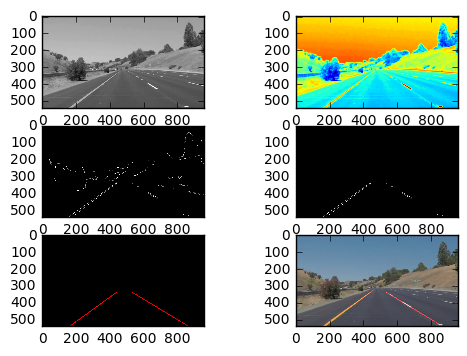

In [220]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [222]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


There are various possibility for improvements. 
first, my region is hardcoded, in real life, this is not likely going to hold true. as people will shift lanes and change directions. your "field of view" likely need to make up of different polygons then a static trapezoid. 

Second, in my current implementation, i seem to have bugs, (occassiona lines across the screen in videos). This is likely due to deteting points that shouldn't be part of the dataset. Probably also need better drawline approximation, max/min is somewhat hacky and doesn't take into account all the datapoints.  

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:35<00:00,  7.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 29.1 s, sys: 5.15 s, total: 34.2 s
Wall time: 36.6 s


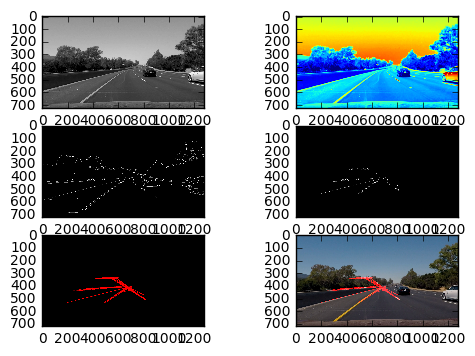

In [141]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))